In [1]:
import pandas as pd
import numpy as np
import os
os.chdir('../../../../')
print(os.getcwd())
from v2.strategy.indicators.optimal_v2 import Optimal_v2
from v2.model import Trading
from v2.strategy.indicators.param import Param
from v2.strategy.indicators.roc import RateOfChange
from v2.research.scripts.notebook_utils import notebookUtils
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance


/Users/rosscopeland/Desktop/personal/code/vivaldi/back_testing


In [2]:
nu = notebookUtils()
model_name = "random_forest"

In [11]:
dataset, features, indicators, scalers = nu.loadData(indicators=[('rsi', 'close'), ('optimal_v2', 'close')],
                            param_spec={},
                            optimal_threshold={'buy':0.8},
                            spans=[{'indicator_name':'willr',
                                    'column_name': 'close',
                                    'param_name': 'period',
                                    'param_values': [3,5,10,30]},
                                    {'indicator_name':'cci',
                                    'column_name': 'close',
                                    'param_name': 'period',
                                    'param_values': [3,5,10,30]},
                                    {'indicator_name':'rsi',
                                    'column_name': 'close',
                                    'param_name': 'period',
                                    'param_values': [3,5,10,30]},
                                    {'indicator_name':'momentum',
                                    'column_name': 'close',
                                    'param_name': 'period',
                                    'param_values': [3,5,10,30]},
                                    {'indicator_name':'roc',
                                    'column_name': 'close',
                                    'param_name': 'period',
                                    'param_values': [3,5,10,30]},
                                    {'indicator_name':'momentum',
                                    'column_name': 'RSI',
                                    'param_name': 'period',
                                    'param_values': [3,5,10,30]},
                                    {'indicator_name':'roc',
                                    'column_name': 'RSI',
                                    'param_name': 'period',
                                    'param_values': [3,5,10,30]},
                                    {'indicator_name':'roc',
                                    'column_name': 'volume',
                                    'param_name': 'period',
                                    'param_values': [3,5,10,30]}
                                    ],

                            scale='minmax')
        
    # create one minute, five minute, ten minute, and twenty minute slopes for macd, rsi




Loading data from BTCUSDT-1m...


In [12]:
edit_dataset = dataset.drop(["time", "open", "high", "low"], axis=1)
edit_dataset.dropna(inplace=True)
edit_dataset

,close,volume,RSI,optimal,WILLR_close_period_3,WILLR_close_period_5,WILLR_close_period_10,WILLR_close_period_30,CCI_close_period_3,CCI_close_period_5,...,Momentum_RSI_period_10,Momentum_RSI_period_30,RateOfChange_RSI_period_3,RateOfChange_RSI_period_5,RateOfChange_RSI_period_10,RateOfChange_RSI_period_30,RateOfChange_volume_period_3,RateOfChange_volume_period_5,RateOfChange_volume_period_10,RateOfChange_volume_period_30
90,4319.996912,0.048053,0.594297,0.0,0.476929,0.488858,0.498613,0.643434,0.933333,0.724138,...,0.494352,0.555047,0.204404,0.181143,0.174906,0.162865,-0.939470,-2.316437e-01,-0.800963,3.752235e+06
91,4319.998456,0.030719,0.594297,0.0,0.476929,0.488858,0.498774,0.643497,0.933333,0.724138,...,0.494352,0.555047,0.204404,0.181143,0.174906,0.162865,-0.828394,1.894869e+06,-0.505617,-8.585486e-01
92,4319.999228,0.179059,0.594297,0.0,0.476929,0.488858,0.498855,0.643529,0.933333,0.724138,...,0.494352,0.570287,0.204404,0.181143,0.174906,0.167805,-0.696787,-7.744488e-01,-0.918101,3.818413e-01
93,4319.999614,0.501599,0.594297,0.0,0.476929,0.488858,0.498936,0.643545,0.933333,0.724138,...,0.497380,0.513006,0.204404,0.181143,0.175860,0.150353,9.438453,1.802088e+00,-0.878017,-8.459927e-01
94,4319.999807,0.019386,0.594297,0.0,0.476929,0.488858,0.498936,0.643552,0.933333,0.724138,...,0.495070,0.513006,0.204404,0.181143,0.175132,0.150353,-0.368925,-9.671723e-01,-0.990685,-9.621465e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1722408,18519.207620,5.437391,0.492830,0.0,0.476624,0.487401,0.429327,0.055142,0.909239,0.392106,...,0.465718,0.456943,0.203943,0.181977,0.164825,0.131905,-0.651461,-6.974313e-01,-0.798477,-9.323983e-01
1722409,18523.983810,65.068932,0.501578,0.0,0.476442,0.486870,0.436562,0.109340,1.000000,1.000000,...,0.473094,0.472400,0.210987,0.182209,0.167435,0.136492,0.902934,1.332889e+01,-0.509884,-1.334584e-01
1722410,18525.301905,15.367476,0.499362,0.0,0.476460,0.486943,0.438859,0.122343,0.680400,0.629556,...,0.494905,0.485892,0.210179,0.183429,0.175072,0.140253,-0.004559,-1.493904e-02,-0.206632,-6.457471e-01
1722411,18526.950952,54.298657,0.501485,0.0,0.476483,0.487035,0.441733,0.138611,0.479043,0.561493,...,0.496661,0.478026,0.208712,0.186509,0.175710,0.138068,8.986160,5.879582e-01,0.994133,-1.313580e-01


In [13]:
trainX, testX, trainy, testy = nu.splitData(edit_dataset, split_size=0.2, y_column_name="optimal", shuffle_data=False, balance_unbalanced_data=True, balance_info={'multiplier_val':4, 'superset_class_val':0, 'randomize_concat':True})
trainX

,close,volume,RSI,WILLR_close_period_3,WILLR_close_period_5,WILLR_close_period_10,WILLR_close_period_30,CCI_close_period_3,CCI_close_period_5,CCI_close_period_10,...,Momentum_RSI_period_10,Momentum_RSI_period_30,RateOfChange_RSI_period_3,RateOfChange_RSI_period_5,RateOfChange_RSI_period_10,RateOfChange_RSI_period_30,RateOfChange_volume_period_3,RateOfChange_volume_period_5,RateOfChange_volume_period_10,RateOfChange_volume_period_30
0,7244.691449,41.997180,0.579366,0.476620,0.487859,0.467714,0.796607,0.920478,0.796264,0.738075,...,0.520687,0.653782,0.217264,0.194554,0.183666,0.200589,-0.128686,3.640416,0.673297,0.189490
1,3428.618446,5.027120,0.463172,0.476591,0.487546,0.438421,0.182900,0.333333,0.372314,0.384012,...,0.453507,0.480415,0.201322,0.178242,0.160106,0.137312,-0.069191,-0.735614,-0.172513,-0.336423
2,9322.151057,12.434114,0.465016,0.476581,0.488091,0.485265,0.552972,0.963420,0.734891,0.664473,...,0.574099,0.533753,0.215855,0.206881,0.210266,0.154867,-0.110039,-0.115319,-0.682313,0.153110
3,3385.389574,20.771637,0.463941,0.476693,0.488257,0.476941,0.397920,1.000000,0.872124,0.618584,...,0.495396,0.552467,0.208795,0.196360,0.175258,0.161819,0.106336,-0.469165,-0.030656,-0.097519
4,7960.183879,9.044255,0.574103,0.476518,0.487841,0.457219,0.726127,0.509654,0.523659,0.526410,...,0.473906,0.611470,0.199525,0.192041,0.168480,0.183036,-0.728999,-0.399345,-0.776643,0.000827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228650,3435.184595,40.626312,0.557917,0.476545,0.487706,0.469470,0.781208,0.849160,0.756397,0.664964,...,0.494925,0.585338,0.205307,0.186567,0.175084,0.173486,3.322686,4.510393,1.228296,1.358948
228651,8664.619292,15.909180,0.498447,0.476602,0.487163,0.439764,0.563316,0.443714,0.229322,0.281861,...,0.463287,0.583259,0.195866,0.171244,0.164111,0.173720,0.014710,-0.596076,-0.442589,-0.476849
228652,10515.384604,12.242716,0.546041,0.476713,0.488014,0.488943,0.889763,0.964943,0.848602,0.645067,...,0.560761,0.608425,0.205801,0.185397,0.199683,0.182732,-0.339302,-0.664055,-0.591992,-0.836294
228653,5036.156090,120.681846,0.457392,0.476638,0.487971,0.483443,0.837204,0.820435,0.742022,0.659919,...,0.568709,0.622152,0.217302,0.189365,0.208034,0.193049,0.164025,-0.717470,-0.648701,0.533718


In [14]:
class_weights = nu.getWeights(trainy)
class_weights

{0: 0.625, 1: 2.5}

In [15]:
clf = RandomForestClassifier(random_state=69420, class_weight=class_weights, n_jobs=-1, n_estimators=100, criterion='gini', min_samples_leaf=1)
clf.fit(trainX.drop("close", axis=1).values, trainy.values)

print(clf.score(testX.drop("close", axis=1).values, testy.values))

feature_importances = permutation_importance(clf, trainX.drop("close", axis=1).values, trainy.values, n_repeats=10, random_state=69420)

for i in range(len(feature_importances.importances_mean)):
    print('i: {}, Feature: {}, Score: {}'.format(i, trainX.drop("close", axis=1).columns[i], feature_importances.importances_mean[i]))

0.9341121861810746
i: 0, Feature: volume, Score: 0.005918086199733242
i: 1, Feature: RSI, Score: 0.0018385777700028582
i: 2, Feature: WILLR_close_period_3, Score: 0.007260282959043107
i: 3, Feature: WILLR_close_period_5, Score: 0.006162121974153212
i: 4, Feature: WILLR_close_period_10, Score: 0.023383262994467656
i: 5, Feature: WILLR_close_period_30, Score: 0.010965865605388047
i: 6, Feature: CCI_close_period_3, Score: 0.005520981391178859
i: 7, Feature: CCI_close_period_5, Score: 0.016050818919332632
i: 8, Feature: CCI_close_period_10, Score: 0.016723447989328934
i: 9, Feature: CCI_close_period_30, Score: 0.0023887516126916307
i: 10, Feature: RSI_close_period_3, Score: 0.13715903872646568
i: 11, Feature: RSI_close_period_5, Score: 0.08388445474623343
i: 12, Feature: RSI_close_period_10, Score: 0.013330563512715688
i: 13, Feature: RSI_close_period_30, Score: 0.002305219654064006
i: 14, Feature: Momentum_close_period_3, Score: 0.06129802540945969
i: 15, Feature: Momentum_close_period_5,

In [16]:
reduced_classified_data = nu.classifyPoints(clf, testX, predict_proba=False, proba_thresh=0.7, plot_optimal=True, optimal=testy)

In [17]:
smaller_view_data = reduced_classified_data[1000:2000]
smaller_view_data.reset_index(inplace=True)

<Figure size 432x288 with 0 Axes>

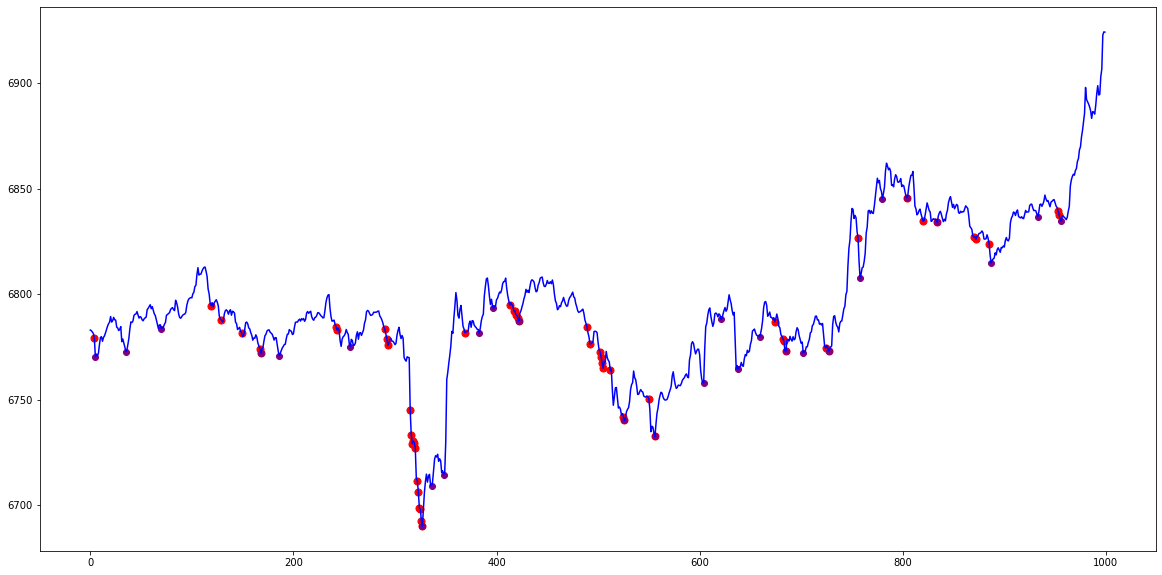

In [18]:
nu.graphPoints(smaller_view_data, mode="buy", plot_optimal=True)

In [23]:
#RUN THIS WHEN YOU WANT TO SAVE MODEL

# nu.exportModel(clf, model_name, new_version=False, indicators=indicators, features=features, proba_threshold=0.0, is_nn=False)